In [1]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import display, SVG
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [2]:
# Filepaths, numpy, and Tensorflow
import os
import numpy as np
import tensorflow as tf

In [3]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.datasets import mnist
from keras.preprocessing import image

Using TensorFlow backend.


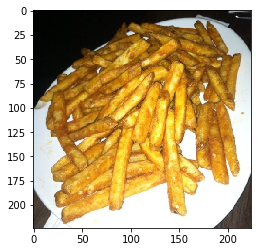

In [33]:
import pandas as pd

trainList = []

f_directories = pd.read_csv('food-101/meta/train.txt', header=None)
fList = f_directories[0].tolist()

for item in fList:
    trainList.append(os.path.join('food-101/image',item + '.jpg'))
    
trainList

trainClasses = [x.split("/")[0] for x in fList]

image_path = trainList[30067]
image_size = (224,224)

img = image.load_img(image_path, target_size=image_size)

plt.imshow(img)

In [35]:
os.getcwd()

'/Users/iqbalsandhu/Desktop/Homework/Group_Project'

In [ ]:
from sklearn.model_selection import tran_test_split

X = 
y = 


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("Training Data Info")
print("Training Data Shape:", X_train.shape)
print("Training Data Labels Shape:", y_train.shape)